In [296]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import os
import sys
from itertools import product
from typing import List

import matplotlib.pyplot as plt
import pandas as pd

sys.path.append("../../../")
from src.athena import Athena
from src.utils import create_session

## Global

In [297]:
boto3_session = create_session(
    profile_name="dev",
    role_arn=os.getenv("ATHENA_IAM_ROLE_ARN"),
)

wait = True
ctas_approach = False
storage_format = "PARQUET"
write_compression = "SNAPPY"

database = "data_mart"
tables = ["weekly_sales"]
sql_path = "../sql/"

athena = Athena(boto3_session=boto3_session, s3_output=os.getenv("ATHENA_S3_OUTPUT"))
athena

Athena(boto3_session=Session(region_name='us-east-1'), s3_output=s3://sql-case-studies/query_results)

## Problem Statement

Data Mart is an international supermarket specializing in fresh produce, operating through both retail and online platforms using a multi-region strategy. In June 2020, the company introduced sustainability-driven changes by implementing sustainable packaging methods across all products and stages of operation, from production to delivery.  

The objective of this analysis is to evaluate the impact of these changes on sales performance and address the following key questions:  

1. What was the quantifiable impact of the sustainable packaging initiative on overall sales performance?  
2. Which platform, region, segment, and customer type experienced the most significant impact from the changes?  
3. What strategies can be implemented to minimize potential negative effects on sales when introducing similar sustainability updates in the future?  

The analysis will utilize the available dataset, `data_mart.weekly_sales`, to generate actionable insights and recommendations.

## Entity Relationship Diagram

<center>
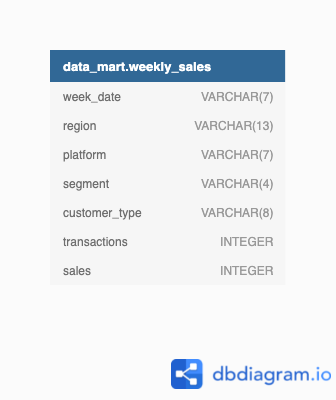
</center>

### Weekly Sales

* **week_date**: The starting date of the sales week for each record.  

* **region**: Represents the geographical area of operations within Data Mart's multi-region strategy.  

* **platform**: Indicates whether sales occurred through the retail channel or the online Shopify storefront.  

* **customer_segment**: Categorizes customers based on demographic and age-related groupings.  

* **customer_type**: Provides additional demographic details, such as lifestyle or purchasing behavior.  

* **transactions**: The count of unique purchases made during the corresponding sales week.  

* **sales**: The total dollar amount of purchases made in the corresponding sales week.  

## Tables

In [3]:
for table in tables:
    athena.query(
        database=database,
        query=f""" 
                SELECT
                    *
                FROM
                    {database}.{table} TABLESAMPLE BERNOULLI(30);
              """,
        ctas_approach=ctas_approach,
    )

,week_date,region,platform,segment,customer_type,transactions,sales
0,2020-08-31,ASIA,Retail,C3,New,120631,3656163.0
1,2020-08-31,ASIA,Retail,F1,New,31574,996575.0
2,2020-08-31,USA,Retail,<NA>,Guest,529151,16509610.0
3,2020-08-31,USA,Shopify,F1,Existing,1398,260773.0
4,2020-08-31,OCEANIA,Shopify,C2,Existing,4661,882690.0
...,...,...,...,...,...,...,...
5060,2018-03-26,CANADA,Retail,<NA>,Guest,456449,12133134.0
5061,2018-03-26,CANADA,Shopify,F1,Existing,371,68811.0
5062,2018-03-26,AFRICA,Retail,C2,Existing,82495,3886146.0
5063,2018-03-26,EUROPE,Shopify,F3,New,2,300.0


## Sanity Checks

### Duplicates

In [4]:
for table in tables:
    query = f"""
    WITH deduped_data AS (
        SELECT
            DISTINCT *
        FROM
            {database}.{table}
    )
    SELECT
        COUNT(*) AS unique_count_{table}
    FROM
        deduped_data;
    """
    athena.query(database=database, query=query, ctas_approach=ctas_approach)

,unique_count_weekly_sales
0,17117


In [5]:
query = """ 
WITH grouped_counts AS (
    SELECT
        week_date,
        region,
        platform,
        segment,
        customer_type,
        transactions,
        sales,
        COUNT(*) AS freq
    FROM
        data_mart.weekly_sales
    GROUP BY
        week_date,
        region,
        platform,
        segment,
        customer_type,
        transactions,
        sales
)
SELECT
    *
FROM
    grouped_counts
WHERE
    freq > 1
ORDER BY
    freq DESC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,week_date,region,platform,segment,customer_type,transactions,sales,freq


### Nullity

In [10]:
query = """
    SELECT 
        column_name 
    FROM 
        information_schema.columns 
    WHERE 
        1 = 1
        AND table_name = 'weekly_sales' 
        AND table_schema = 'data_mart';
"""

column_names = athena.query(
    database=database, query=query, ctas_approach=ctas_approach
).values.flatten()
column_names

array(['week_date', 'region', 'platform', 'segment', 'customer_type',
       'transactions', 'sales'], dtype=object)

In [12]:
select_clauses = []
for col in column_names:
    select_clauses.append(
        f"'{col}' AS column_name, "
        f"SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) AS null_count, "
        f"ROUND(100.0 * SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS null_percentage"
    )

select_query = " UNION ALL ".join(
    [f"SELECT {clause} FROM data_mart.weekly_sales" for clause in select_clauses]
)

query = f"""{select_query};"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,column_name,null_count,null_percentage
0,transactions,0,0.00
1,region,0,0.00
2,week_date,0,0.00
3,platform,0,0.00
4,segment,3024,17.67
5,customer_type,0,0.00
6,sales,0,0.00


## EDA

### Unique Categories

In [13]:
categorical_cols = ["region", "platform", "segment", "customer_type"]
for col in categorical_cols:
    query = f""" 
    SELECT
        DISTINCT {col}  
    FROM
        data_mart.weekly_sales;
    """
    athena.query(database=database, query=query, ctas_approach=ctas_approach)

,region
0,USA
1,EUROPE
2,AFRICA
3,SOUTH AMERICA
4,CANADA
5,ASIA
6,OCEANIA


,platform
0,Retail
1,Shopify


,segment
0,F3
1,C3
2,F2
3,C4
4,C2
5,F1
6,<NA>
7,C1


,customer_type
0,New
1,Existing
2,Guest


### Sales Distribution

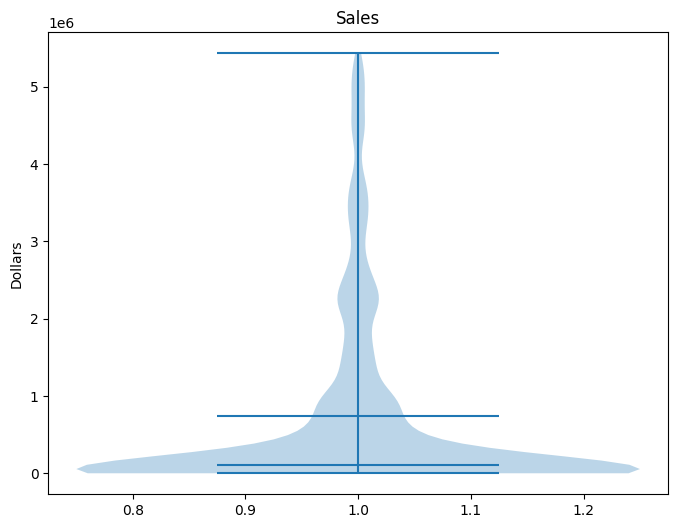

In [18]:
query = """
SELECT 
    sales 
FROM 
    data_mart.weekly_sales
WHERE 
    1 = 1
    AND sales <= (
        SELECT
            APPROX_PERCENTILE(sales , 0.90)
        FROM
            data_mart.weekly_sales
    );
"""
sales = athena.query(database=database, query=query, ctas_approach=ctas_approach)

plt.figure(figsize=(8, 6))
plt.violinplot(sales, showmeans=True, showextrema=True, showmedians=True)
plt.title("Sales")
plt.ylabel("Dollars")
plt.show();

In [23]:
query = """
SELECT 
    AVG(sales) / 1000000.0 AS mean_sales_millions,
    STDDEV(sales) / 1000000.0 AS std_sales_millions,
    APPROX_PERCENTILE(sales, 0.25) / 1000000.0 AS pct_25_millions,
    APPROX_PERCENTILE(sales, 0.50) / 1000000.0 AS median_millions,
    APPROX_PERCENTILE(sales, 0.75) / 1000000.0 AS pct_75_millions
FROM 
    data_mart.weekly_sales;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,mean_sales_millions,std_sales_millions,pct_25_millions,median_millions,pct_75_millions
0,2.380302,6.973521,0.02535,0.220297,1.656853


### Transactions Count Distribution

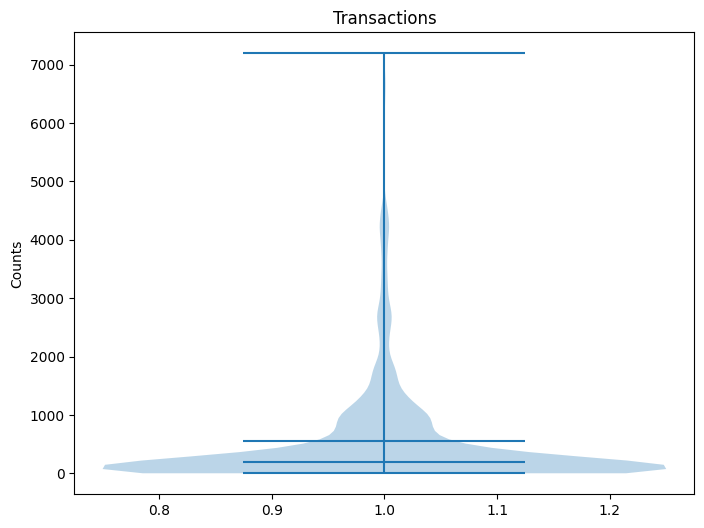

In [19]:
query = """
SELECT 
    transactions 
FROM 
    data_mart.weekly_sales
WHERE 
    1 = 1
    AND sales <= (
        SELECT
            APPROX_PERCENTILE(transactions, 0.95)
        FROM
            data_mart.weekly_sales
    );
"""
sales = athena.query(database=database, query=query, ctas_approach=ctas_approach)

plt.figure(figsize=(8, 6))
plt.violinplot(sales, showmeans=True, showextrema=True, showmedians=True)
plt.title("Transactions")
plt.ylabel("Counts")
plt.show();

In [25]:
query = """
SELECT 
    AVG(transactions) AS mean_transactions,
    STDDEV(transactions) AS std_transactions,
    APPROX_PERCENTILE(transactions, 0.25) AS pct_25,
    APPROX_PERCENTILE(transactions, 0.50) AS median,
    APPROX_PERCENTILE(transactions, 0.75) AS pct_75
FROM 
    data_mart.weekly_sales;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,mean_transactions,std_transactions,pct_25,median,pct_75
0,63554.325875,237625.690744,181,1855,40903


### Sampling Period

In [28]:
query = """ 
SELECT
    MAX(week_date) AS max_date,
    MIN(week_date) AS min_date,
    DATE_DIFF('DAY', MIN(week_date), MAX(week_date)) AS days_difference,
    DATE_DIFF('MONTH', MIN(week_date), MAX(week_date)) AS months_difference,
    DATE_DIFF('YEAR', MIN(week_date), MAX(week_date)) AS years_difference
FROM
    data_mart.weekly_sales;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,max_date,min_date,days_difference,months_difference,years_difference
0,2020-08-31,2018-03-26,889,29,2


## Data Cleaning

For `week_number`, the approach is to use `CEIL` function to round up the division of `DAY_OF_YEAR` by 7:

```sql
CAST(CEIL(DAY_OF_YEAR(week_date) / 7.0) AS INTEGER) AS week_number
```

In [81]:
query = """ 
SELECT
    week_date,
    CAST(CEIL(DAY_OF_YEAR(week_date) / 7.0) AS INTEGER) AS week_number,
    EXTRACT(MONTH FROM week_date) AS month_number,
    EXTRACT(YEAR FROM week_date) AS calendar_year,

    COALESCE(segment, 'Unknown') AS segment,
    CASE 
        WHEN SUBSTRING(segment, -1, 1) = '1' THEN 'Young Adults'
        WHEN SUBSTRING(segment, -1, 1) = '2' THEN 'Middle Aged'
        WHEN SUBSTRING(segment, -1, 1) IN ('3', '4') THEN 'Retirees'
        ELSE 'Unknown'
    END AS age_band,
    CASE 
        WHEN SUBSTRING(segment, 1, 1) = 'C' THEN 'Couples'
        WHEN SUBSTRING(segment, 1, 1) = 'F' THEN 'Families'
        ELSE 'Unknown'
    END AS demographics,

    region,
    platform,
    customer_type,

    transactions,
    ROUND(sales / transactions, 2) AS avg_transaction,
    sales
FROM
    data_mart.weekly_sales;
"""

athena.create_ctas_table(
    database=database,
    query=query,
    ctas_table="sales",
    s3_output="s3://sql-case-studies/data_mart/sales/",
    storage_format=storage_format,
    write_compression=write_compression,
    wait=wait,
)

{'ctas_database': 'data_mart',
 'ctas_table': 'sales',
 'ctas_query_metadata': _QueryMetadata(execution_id='c8df1006-7397-4bbd-9384-e66616336ec2', dtype={'rows': 'Int64'}, parse_timestamps=[], parse_dates=[], parse_geometry=[], converters={}, binaries=[], output_location='s3://sql-case-studies/data_mart/sales/tables/c8df1006-7397-4bbd-9384-e66616336ec2', manifest_location='s3://sql-case-studies/data_mart/sales/tables/c8df1006-7397-4bbd-9384-e66616336ec2-manifest.csv', raw_payload={'QueryExecutionId': 'c8df1006-7397-4bbd-9384-e66616336ec2', 'Query': 'CREATE TABLE "data_mart"."sales"\nWITH(\n    external_location = \'s3://sql-case-studies/data_mart/sales/sales\',\n    write_compression = \'SNAPPY\',\n    format = \'PARQUET\')\nAS  \nSELECT\n    week_date,\n    CAST(CEIL(DAY_OF_YEAR(week_date) / 7.0) AS INTEGER) AS week_number,\n    EXTRACT(MONTH FROM week_date) AS month_number,\n    EXTRACT(YEAR FROM week_date) AS calendar_year,\n\n    COALESCE(segment, \'Unknown\') AS segment,\n    CASE

In [83]:
athena.query(
    database=database,
    query="SELECT * FROM data_mart.sales TABLESAMPLE BERNOULLI(30);",
    ctas_approach=ctas_approach,
)

,week_date,week_number,month_number,calendar_year,segment,age_band,demographics,region,platform,customer_type,transactions,avg_transaction,sales
0,2020-08-31,35,8,2020,C3,Retirees,Couples,ASIA,Retail,New,120631,30.31,3656163.0
1,2020-08-31,35,8,2020,C2,Middle Aged,Couples,AFRICA,Retail,New,58046,30.29,1758388.0
2,2020-08-31,35,8,2020,F2,Middle Aged,Families,CANADA,Shopify,Existing,1336,182.54,243878.0
3,2020-08-31,35,8,2020,F3,Retirees,Families,AFRICA,Shopify,Existing,2514,206.64,519502.0
4,2020-08-31,35,8,2020,F2,Middle Aged,Families,AFRICA,Shopify,New,318,155.84,49557.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5129,2018-03-26,13,3,2018,C2,Middle Aged,Couples,ASIA,Retail,New,72058,27.87,2008197.0
5130,2018-03-26,13,3,2018,F1,Young Adults,Families,USA,Shopify,Existing,980,203.76,199685.0
5131,2018-03-26,13,3,2018,F1,Young Adults,Families,SOUTH AMERICA,Shopify,New,3,225.67,677.0
5132,2018-03-26,13,3,2018,F3,Retirees,Families,EUROPE,Shopify,New,2,150.00,300.0


## Data Exploration

## Q1 

What day of the week is used for each `week_date` value?

In [84]:
query = """ 
SELECT
    DISTINCT DAY_OF_WEEK(week_date) AS day_of_week
FROM
    data_mart.sales;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,day_of_week
0,1


## Q2

What range of week numbers are missing from the dataset?

In [87]:
query = """ 
SELECT
    DISTINCT week_number
FROM
    data_mart.sales
ORDER BY
    week_number DESC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,week_number
0,36
1,35
2,34
3,33
4,32
5,31
6,30
7,29
8,28
9,27


Weeks 1 to 11 are missing in the dataset.

## Q3

How many total `transactions` were there for each year in the dataset?

In [91]:
query = """ 
SELECT
    calendar_year,
    SUM(transactions) / 1000000.0 AS total_transactions_millions
FROM
    data_mart.sales
GROUP BY
    calendar_year
ORDER BY
    total_transactions_millions DESC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,calendar_year,total_transactions_millions
0,2020,375.813651
1,2019,365.639285
2,2018,346.406460


## Q4

What is the total sales for each region for each month?

In [137]:
query = """ 
SELECT
    region,
    DATE_TRUNC('MONTH', week_date) AS month_year,
    SUM(sales) / 1000000.0 AS total_sales_millions
FROM
    data_mart.sales
GROUP BY
    region,
    DATE_TRUNC('MONTH', week_date)
ORDER BY
    region ASC,
    DATE_TRUNC('MONTH', week_date) ASC;
"""

sales_by_region_month = athena.query(
    database=database, query=query, ctas_approach=ctas_approach
)
sales_by_region_month.head(10)

,region,month_year,total_sales_millions
0,AFRICA,2018-03-01,130.542211
1,AFRICA,2018-04-01,650.194752
2,AFRICA,2018-05-01,522.814996
3,AFRICA,2018-06-01,519.127097
4,AFRICA,2018-07-01,674.135864
5,AFRICA,2018-08-01,539.077368
6,AFRICA,2018-09-01,135.084533
7,AFRICA,2019-03-01,141.619350
8,AFRICA,2019-04-01,700.447296
9,AFRICA,2019-05-01,553.828220


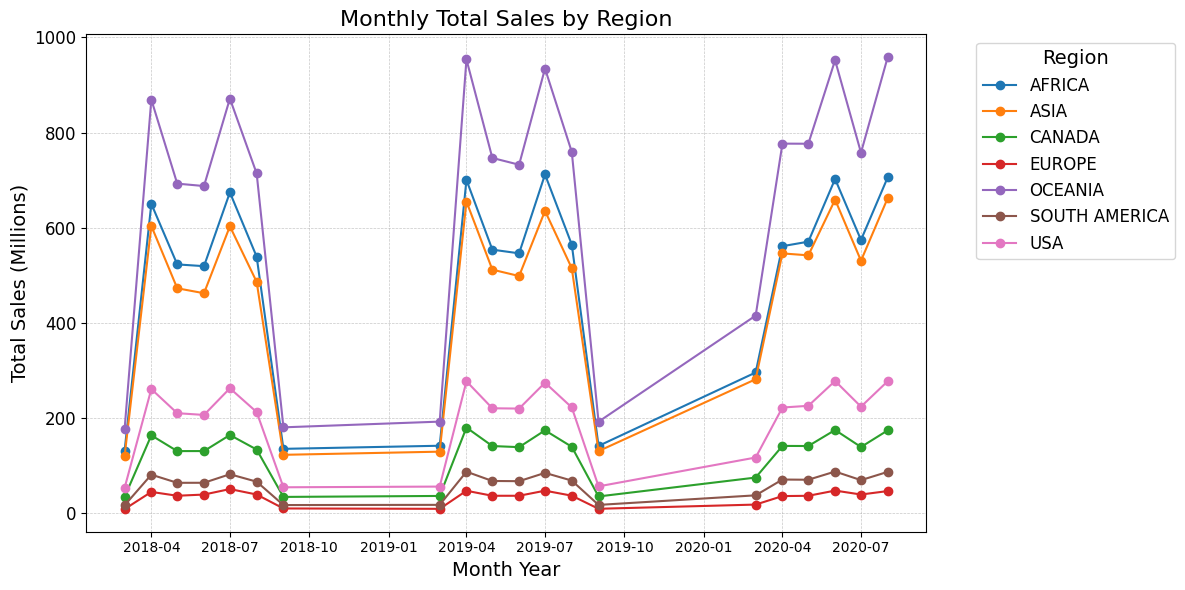

In [138]:
plt.figure(figsize=(12, 6))

# Plot data for each region
for region, group in sales_by_region_month.groupby("region"):
    plt.plot(
        group["month_year"], group["total_sales_millions"], label=region, marker="o"
    )

plt.title("Monthly Total Sales by Region", fontsize=16)
plt.xlabel("Month Year", fontsize=14)
plt.ylabel("Total Sales (Millions)", fontsize=14)
plt.yticks(fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.legend(
    title="Region",
    fontsize=12,
    title_fontsize=14,
    loc="upper left",
    bbox_to_anchor=(1.05, 1.0),  # Move legend outside the plot
)
plt.tight_layout()
plt.show();

## Q5

What is the total count of transactions for each platform?

In [100]:
query = """ 
SELECT
    platform,
    SUM(transactions) / 100000.0 AS total_transactions_millions
FROM
    data_mart.sales
GROUP BY
    platform
ORDER BY
    total_transactions_millions DESC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,platform,total_transactions_millions
0,Retail,10819.34227
1,Shopify,59.25169


## Q6

What is the percentage of sales for Retail vs Shopify for each month?

In [147]:
query = """ 
WITH sales_pct_by_platform AS (
    SELECT
        DATE_TRUNC('MONTH', week_date) AS month_year,
        platform,
        SUM(sales) * 100.0 / SUM(SUM(sales)) OVER(PARTITION BY DATE_TRUNC('MONTH', week_date)) AS sales_pct
    FROM
        data_mart.sales
    GROUP BY
        DATE_TRUNC('MONTH', week_date),
        platform
    ORDER BY
        DATE_TRUNC('MONTH', week_date),
        platform
)
SELECT
    month_year,
    MAX(CASE WHEN platform = 'Retail' THEN sales_pct ELSE NULL END) AS retail,
    MAX(CASE WHEN platform = 'Shopify' THEN sales_pct ELSE NULL END) AS shopify
FROM
    sales_pct_by_platform
GROUP BY
    month_year
ORDER BY
    month_year ASC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,month_year,retail,shopify
0,2018-03-01,97.918532,2.081468
1,2018-04-01,97.925940,2.074060
2,2018-05-01,97.727866,2.272134
3,2018-06-01,97.755527,2.244473
4,2018-07-01,97.753021,2.246979
5,2018-08-01,97.706277,2.293723
6,2018-09-01,97.678574,2.321426
7,2019-03-01,97.706553,2.293447
8,2019-04-01,97.800180,2.199820
9,2019-05-01,97.524904,2.475096


Another approach is to use a CTE:

In [146]:
query = """ 
WITH monthly_totals AS (
    SELECT
        DATE_TRUNC('MONTH', week_date) AS month_year,
        SUM(sales) AS total_sales
    FROM
        data_mart.sales
    GROUP BY
        DATE_TRUNC('MONTH', week_date)
),
sales_pct_by_platform AS (
    SELECT
        DATE_TRUNC('MONTH', s.week_date) AS month_year,
        s.platform,
        SUM(s.sales) * 100.0 / t.total_sales AS sales_pct
    FROM
        data_mart.sales AS s 
            INNER JOIN monthly_totals AS t ON DATE_TRUNC('MONTH', s.week_date) = t.month_year
    GROUP BY
        DATE_TRUNC('MONTH', s.week_date), 
        s.platform, 
        t.total_sales
    ORDER BY
        DATE_TRUNC('MONTH', s.week_date), 
        s.platform
)
SELECT
    month_year,
    MAX(CASE WHEN platform = 'Retail' THEN sales_pct ELSE NULL END) AS retail,
    MAX(CASE WHEN platform = 'Shopify' THEN sales_pct ELSE NULL END) AS shopify
FROM
    sales_pct_by_platform
GROUP BY
    month_year
ORDER BY
    month_year ASC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,month_year,retail,shopify
0,2018-03-01,97.918532,2.081468
1,2018-04-01,97.925940,2.074060
2,2018-05-01,97.727866,2.272134
3,2018-06-01,97.755527,2.244473
4,2018-07-01,97.753021,2.246979
5,2018-08-01,97.706277,2.293723
6,2018-09-01,97.678574,2.321426
7,2019-03-01,97.706553,2.293447
8,2019-04-01,97.800180,2.199820
9,2019-05-01,97.524904,2.475096


## Q7

What is the percentage of sales by demographic for each year in the dataset?

In [113]:
query = """ 
SELECT
    calendar_year,
    demographics,
    SUM(sales) * 100.0 / SUM(SUM(sales)) OVER(PARTITION BY calendar_year) AS sales_pct
FROM
    data_mart.sales
GROUP BY
    calendar_year,
    demographics
ORDER BY
    calendar_year,
    demographics;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,calendar_year,demographics,sales_pct
0,2018,Couples,26.380462
1,2018,Families,31.987565
2,2018,Unknown,41.631973
3,2019,Couples,27.275157
4,2019,Families,32.474231
5,2019,Unknown,40.250612
6,2020,Couples,28.719883
7,2020,Families,32.725289
8,2020,Unknown,38.554828


## Q8

Which `age_band` and `demographic` values contribute the most to Retail sales?

In [153]:
query = """ 
SELECT
    age_band,
    demographics,
    SUM(SUM(sales)) OVER(PARTITION BY age_band) / 1000000.0 AS total_sales_millions_by_age_band,
    SUM(SUM(sales)) OVER(PARTITION BY demographics) / 1000000.0 AS total_sales_millions_by_demographics,
    SUM(sales) / 1000000.0 AS total_sales_millions_by_age_demo
FROM
    data_mart.sales
WHERE
    1 = 1
    AND platform IN ('Retail')
GROUP BY
    age_band,
    demographics
ORDER BY
    age_band,
    demographics;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,age_band,demographics,total_sales_millions_by_age_band,total_sales_millions_by_demographics,total_sales_millions_by_age_demo
0,Middle Aged,Couples,6208.251885,10827.663141,1854.160330
1,Middle Aged,Families,6208.251885,12759.667756,4354.091555
2,Retirees,Couples,13005.266922,10827.663141,6370.580014
3,Retirees,Families,13005.266922,12759.667756,6634.686908
4,Unknown,Unknown,16067.285525,16067.285525,16067.285525
5,Young Adults,Couples,4373.812090,10827.663141,2602.922797
6,Young Adults,Families,4373.812090,12759.667756,1770.889293


In [150]:
query = """ 
SELECT
    age_band,
    SUM(sales) / 1000000.0 AS total_sales_millions,
    SUM(sales) * 100.0 / SUM(SUM(sales)) OVER() AS sales_pct
FROM
    data_mart.sales
WHERE
    1 = 1
    AND platform IN ('Retail')
GROUP BY
    age_band
ORDER BY
    total_sales_millions DESC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,age_band,total_sales_millions,sales_pct
0,Unknown,16067.285525,40.518071
1,Retirees,13005.266922,32.796350
2,Middle Aged,6208.251885,15.655811
3,Young Adults,4373.812090,11.029768


In [152]:
query = """ 
SELECT
    demographics,
    SUM(sales) / 1000000.0 AS total_sales_millions,
    SUM(sales) * 100.0 / SUM(SUM(sales)) OVER() AS sales_pct
FROM
    data_mart.sales
WHERE
    1 = 1
    AND platform IN ('Retail')
GROUP BY
    demographics
ORDER BY
    total_sales_millions DESC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,demographics,total_sales_millions,sales_pct
0,Unknown,16067.285525,40.518071
1,Families,12759.667756,32.177005
2,Couples,10827.663141,27.304925


## Q9

Can we use the `avg_transaction` column to find the average transaction size for each year for Retail vs Shopify? If not - how would you calculate it instead?

$$
\text{Average Transaction} = \frac{\text{Total Sales in Dollars}}{\text{Total Transactions}}
$$

This formula essentially calculates the average sales amount per transaction for each combination of the columns, i.e., `week_date`, `segment`, `customer_type`, `platform`, and `region`.

In order to calculate the average transasction size for each year for Retail vs Shopify, we must group by `year`, `platform`, and `week_date` and then calculate the average transaction size.

In [129]:
query = """ 
SELECT
    calendar_year,
    platform,
    ROUND(SUM(sales) / SUM(transactions), 2) AS avg_transaction
FROM
    data_mart.sales
GROUP BY
    calendar_year,
    platform
ORDER BY
    calendar_year,
    platform;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,calendar_year,platform,avg_transaction
0,2018,Retail,36.56
1,2018,Shopify,192.48
2,2019,Retail,36.83
3,2019,Shopify,183.36
4,2020,Retail,36.56
5,2020,Shopify,179.03


## Before & After Analysis

The intervention date is 2020-06-15.

## Q1

What is the total sales for the 4 weeks before and after 2020-06-15? What is the growth or reduction rate in actual values and percentage of sales?

### Not Including the Last Day

```sql
AND week_date >= DATE_ADD('WEEK', -4, DATE '2020-06-15') 
AND week_date < DATE_ADD('WEEK', 4, DATE '2020-06-15')
```

### Including the Last Day

```sql
AND week_date BETWEEN DATE_ADD('WEEK', -4, DATE '2020-06-15') AND DATE_ADD('WEEK', 4, DATE '2020-06-15')
```

### Before & After CTE

In [244]:
query = """
SELECT
    week_date,
    CASE 
        WHEN week_date < DATE '2020-06-15' THEN '1 before' 
        WHEN week_date >= DATE '2020-06-15' THEN '2 after' 
    END AS intervention,
    sales
FROM
    data_mart.sales
WHERE
    1 = 1
    AND week_date >= DATE_ADD('WEEK', -4, DATE '2020-06-15') 
    AND week_date < DATE_ADD('WEEK', 4, DATE '2020-06-15');
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,week_date,intervention,sales
0,2020-07-06,2 after,275749.0
1,2020-07-06,2 after,7059529.0
2,2020-07-06,2 after,12375.0
3,2020-07-06,2 after,359403.0
4,2020-07-06,2 after,48780232.0
...,...,...,...
1899,2020-05-18,1 before,2146858.0
1900,2020-05-18,1 before,36469.0
1901,2020-05-18,1 before,480498.0
1902,2020-05-18,1 before,258708.0


### Total Sales CTE

In [245]:
query = """ 
WITH before_after AS (
    SELECT
        CASE 
            WHEN week_date < DATE '2020-06-15' THEN '1 before' 
            WHEN week_date >= DATE '2020-06-15' THEN '2 after' 
        END AS intervention,
        sales
    FROM
        data_mart.sales
    WHERE
        1 = 1
        AND week_date >= DATE_ADD('WEEK', -4, DATE '2020-06-15') 
        AND week_date < DATE_ADD('WEEK', 4, DATE '2020-06-15')
)
SELECT
    intervention,
    SUM(sales) / 1000000.0 AS total_sales_millions,
    SUM(sales) * 100.0 / SUM(SUM(sales)) OVER() AS sales_pct
FROM
    before_after
GROUP BY
    intervention;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,intervention,total_sales_millions,sales_pct
0,2 after,2318.994168,49.711844
1,1 before,2345.878357,50.288156


### Sales Metrics CTE

In [249]:
query = """ 
WITH before_after AS (
    SELECT
        CASE 
            WHEN week_date < DATE '2020-06-15' THEN '1 before' 
            WHEN week_date >= DATE '2020-06-15' THEN '2 after' 
        END AS intervention,
        sales
    FROM
        data_mart.sales
    WHERE
        1 = 1
        AND week_date >= DATE_ADD('WEEK', -4, DATE '2020-06-15') 
        AND week_date < DATE_ADD('WEEK', 4, DATE '2020-06-15')
),

total_sales AS (
    SELECT
        intervention,
        SUM(sales) / 1000000.0 AS total_sales_millions,
        SUM(sales) * 100.0 / SUM(SUM(sales)) OVER() AS sales_pct
    FROM
        before_after
    GROUP BY
        intervention
)
SELECT
    intervention,
    total_sales_millions AS total_sales_before,
    sales_pct,
    LAG(total_sales_millions, 1) OVER(ORDER BY intervention) AS total_sales_after,
    100.0 * ((total_sales_millions / LAG(total_sales_millions, 1) OVER(ORDER BY intervention)) - 1) AS sales_pct_change,
    (total_sales_millions - LAG(total_sales_millions, 1) OVER(ORDER BY intervention)) AS sales_difference_millions
FROM
    total_sales;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,intervention,total_sales_before,sales_pct,total_sales_after,sales_pct_change,sales_difference_millions
0,1 before,2345.878357,50.288156,NaN,NaN,NaN
1,2 after,2318.994168,49.711844,2345.878357,-1.146018,-26.884189


### Final Query (Reshape Long to Wide)

In [253]:
def sales_metrics_query(year: int, weeks: int) -> str:
    return f""" 
            WITH before_after AS (
                SELECT
                    CASE 
                        WHEN week_date < DATE '{year}-06-15' THEN '1 before' 
                        WHEN week_date >= DATE '{year}-06-15' THEN '2 after' 
                    END AS intervention,
                    sales
                FROM
                    data_mart.sales
                WHERE
                    1 = 1
                    AND week_date >= DATE_ADD('WEEK', -{weeks}, DATE '{year}-06-15') 
                    AND week_date < DATE_ADD('WEEK', {weeks}, DATE '{year}-06-15')
            ),

            total_sales AS (
                SELECT
                    intervention,
                    SUM(sales) / 1000000.0 AS total_sales_millions,
                    SUM(sales) * 100.0 / SUM(SUM(sales)) OVER() AS sales_pct
                FROM
                    before_after
                GROUP BY
                    intervention
            ),

            sales_metrics AS (
                SELECT
                    intervention,
                    total_sales_millions,
                    sales_pct,
                    100.0 * ((total_sales_millions / LAG(total_sales_millions, 1) OVER(ORDER BY intervention)) - 1) AS sales_pct_change,
                    (total_sales_millions - LAG(total_sales_millions, 1) OVER(ORDER BY intervention)) AS sales_difference_millions
                FROM
                    total_sales
            )
            SELECT
                MAX(CASE WHEN intervention = '1 before' THEN total_sales_millions ELSE NULL END) AS total_sales_milllions_before,
                MAX(CASE WHEN intervention = '2 after' THEN total_sales_millions ELSE NULL END) AS total_sales_milllions_after,

                MAX(CASE WHEN intervention = '1 before' THEN sales_pct ELSE NULL END) AS sales_pct_before,
                MAX(CASE WHEN intervention = '2 after' THEN sales_pct ELSE NULL END) AS sales_pct_after,

                MAX(CASE WHEN intervention = '2 after' THEN sales_pct_change ELSE NULL END) AS sales_pct_change,
                MAX(CASE WHEN intervention = '2 after' THEN sales_difference_millions ELSE NULL END) AS sales_difference_millions
            FROM
                sales_metrics;
            """

In [254]:
query = sales_metrics_query(year=2020, weeks=4)

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,total_sales_milllions_before,total_sales_milllions_after,sales_pct_before,sales_pct_after,sales_pct_change,sales_difference_millions
0,2345.878357,2318.994168,50.288156,49.711844,-1.146018,-26.884189


## Q2

What about the entire 12 weeks before and after?

In [255]:
query = sales_metrics_query(year=2020, weeks=12)

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,total_sales_milllions_before,total_sales_milllions_after,sales_pct_before,sales_pct_after,sales_pct_change,sales_difference_millions
0,7126.273147,6973.947758,50.540152,49.459848,-2.137518,-152.325389


## Q3

How do the sale metrics for these 2 periods before and after compare with the previous years in 2018 and 2019?

In [280]:
query_results: List[pd.DataFrame] = []
for year, weeks in product([2018, 2019, 2020], [4, 12]):
    query: str = sales_metrics_query(year=year, weeks=weeks)
    data: pd.DataFrame = athena.query(
        database=database, query=query, ctas_approach=ctas_approach
    )
    data["year"] = year
    query_results.append(data)

In [289]:
combined_result: pd.DataFrame = pd.concat(query_results, axis=0)
combined_result

,total_sales_milllions_before,total_sales_milllions_after,sales_pct_before,sales_pct_after,sales_pct_change,sales_difference_millions,year
0,2125.140813,2129.242917,49.951790,50.048210,0.193027,4.102104,2018
0,6396.562306,6500.818508,49.595824,50.404176,1.629879,104.256202,2018
0,2249.989797,2252.326389,49.974051,50.025949,0.103849,2.336592,2019
0,6883.386390,6862.646103,50.075441,49.924559,-0.301309,-20.740287,2019
0,2345.878357,2318.994168,50.288156,49.711844,-1.146018,-26.884189,2020
0,7126.273147,6973.947758,50.540152,49.459848,-2.137518,-152.325389,2020


## Bonus

Which areas of the business have the highest negative impact in sales metrics performance in 2020 for the 12 week before and after period?

* Region
* Platform
* Age Band
* Demographic
* Customer Type

In [294]:
def sales_metrics_by_group_query(group_col: str, year: int, weeks: int) -> str:
    return f""" 
            WITH before_after AS (
                SELECT
                    CASE 
                        WHEN week_date < DATE '{year}-06-15' THEN '1 before' 
                        WHEN week_date >= DATE '{year}-06-15' THEN '2 after' 
                    END AS intervention,
                    sales,
                    {group_col}
                FROM
                    data_mart.sales
                WHERE
                    1 = 1
                    AND week_date >= DATE_ADD('WEEK', -{weeks}, DATE '{year}-06-15') 
                    AND week_date < DATE_ADD('WEEK', {weeks}, DATE '{year}-06-15')
            ),

            total_sales AS (
                SELECT
                    {group_col},
                    intervention,
                    SUM(sales) / 1000000.0 AS total_sales_millions,
                    SUM(sales) * 100.0 / SUM(SUM(sales)) OVER(PARTITION BY {group_col}) AS sales_pct
                FROM
                    before_after
                GROUP BY
                    {group_col},
                    intervention
            ),

            sales_metrics AS (
                SELECT
                    {group_col},
                    intervention,
                    total_sales_millions,
                    sales_pct,
                    100.0 * ((total_sales_millions / LAG(total_sales_millions, 1) OVER(PARTITION BY {group_col} ORDER BY intervention)) - 1) AS sales_pct_change,
                    (total_sales_millions - LAG(total_sales_millions, 1) OVER(PARTITION BY {group_col} ORDER BY intervention)) AS sales_difference_millions
                FROM
                    total_sales
            )
            SELECT
                {group_col},

                MAX(CASE WHEN intervention = '1 before' THEN total_sales_millions ELSE NULL END) AS total_sales_millions_before,
                MAX(CASE WHEN intervention = '2 after' THEN total_sales_millions ELSE NULL END) AS total_sales_millions_after,

                MAX(CASE WHEN intervention = '2 after' THEN sales_pct_change ELSE NULL END) AS sales_pct_change,
                MAX(CASE WHEN intervention = '2 after' THEN sales_difference_millions ELSE NULL END) AS sales_difference_millions
            FROM
                sales_metrics
            GROUP BY
                {group_col}
            ORDER BY
                {group_col};
            """

In [295]:
for group_col in ["region", "platform", "age_band", "demographics", "customer_type"]:
    query = sales_metrics_by_group_query(group_col=group_col, year=2020, weeks=12)
    athena.query(database=database, query=query, ctas_approach=ctas_approach)

,region,total_sales_millions_before,total_sales_millions_after,sales_pct_change,sales_difference_millions
0,AFRICA,1709.537097,1700.390303,-0.535045,-9.146794
1,ASIA,1637.244468,1583.807621,-3.263828,-53.436847
2,CANADA,426.438454,418.264441,-1.916810,-8.174013
3,EUROPE,108.886567,114.038959,4.731889,5.152392
4,OCEANIA,2354.116791,2282.795687,-3.029633,-71.321104
5,SOUTH AMERICA,213.036208,208.452033,-2.151829,-4.584175
6,USA,677.013562,666.198714,-1.597434,-10.814848


,platform,total_sales_millions_before,total_sales_millions_after,sales_pct_change,sales_difference_millions
0,Retail,6906.861113,6738.777284,-2.433578,-168.083829
1,Shopify,219.412034,235.170474,7.182122,15.758440


,age_band,total_sales_millions_before,total_sales_millions_after,sales_pct_change,sales_difference_millions
0,Middle Aged,1164.847638,1141.853349,-1.974017,-22.994289
1,Retirees,2395.264509,2365.714998,-1.233664,-29.549511
2,Unknown,2764.354472,2671.961443,-3.342300,-92.393029
3,Young Adults,801.806528,794.417968,-0.921489,-7.388560


,demographics,total_sales_millions_before,total_sales_millions_after,sales_pct_change,sales_difference_millions
0,Couples,2033.589642,2015.977285,-0.866072,-17.612357
1,Families,2328.329033,2286.009030,-1.817613,-42.320003
2,Unknown,2764.354472,2671.961443,-3.342300,-92.393029


,customer_type,total_sales_millions_before,total_sales_millions_after,sales_pct_change,sales_difference_millions
0,Existing,3690.116419,3606.243459,-2.272908,-83.872960
1,Guest,2573.436309,2496.233635,-2.999984,-77.202674
2,New,862.720419,871.470664,1.014262,8.750245


## Clean Up

In [298]:
athena.drop_table(database=database, table="sales", wait=wait)

Query executed successfully
